In [1]:
using DrWatson
@quickactivate "projectdir()"

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, ProgressMeter, Random, Ripserer
using Distances, Distributions, LinearAlgebra, Pipe, Plots, Random, Statistics, StatsBase

In [3]:
function scale_embeddings(X)
    return (X .- mean(eachrow(X))') * (X'X)^(-0.5)
end

function diagram(X, dim_max; alpha=true)
    points = tuple.(eachcol(X)...)
    dgm = ripserer(Alpha(points), dim_max=dim_max)
    return dgm
end

function bottleneck_distances(X, Y, dim_max)
    DX = diagram(X, dim_max)
    DY = diagram(Y, dim_max)
    return [Bottleneck()(DX[d], DY[d]) for d in 2:2]
end

bottleneck_distances (generic function with 1 method)

In [4]:
function generate_lemniscate(n)
    σ = 0.75  # Bandwidth
    Z = rdpg.randLemniscate(n)
    f = (x, y) -> min(1, pdf(Normal(0, σ), norm(x .- y)))
    return rdpg.Adjacency(f, Z)
end

function simulate_one(A, d, epsilon, method)
    X, _, _ = rdpg.spectralEmbed(A, d=d + 1, scale=false)
    
    if method == :eflip
        A_private = rdpg.edgeFlip(A, ϵ=epsilon)
    elseif method == :lflip
        A_private = rdpg.laplaceFlip(A, ϵ=epsilon)
    end

    A_private = A_private .- rdpg.privacy(ϵ=epsilon)
    X_private, _, _ = rdpg.spectralEmbed(A_private, d=d + 1, scale=false)
    X_private = X_private ./ (1 - 2 * rdpg.privacy(ϵ=epsilon))

    return bottleneck_distances(X, X_private, d)
end

simulate_one (generic function with 1 method)

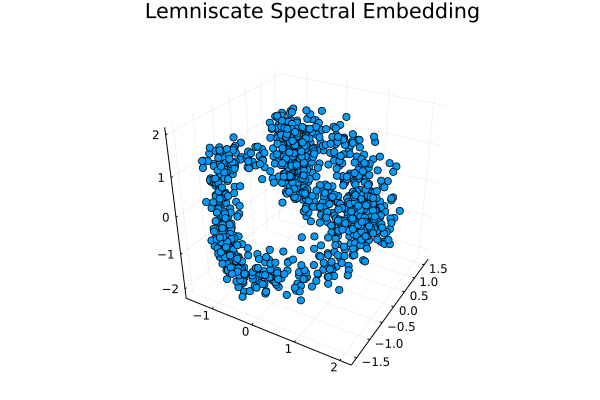

In [5]:
A = generate_lemniscate(1000)
X, _ = rdpg.spectralEmbed(A, d=3)
@pipe [tuple.(x...) for x in eachrow(X)] |> scatter(_, title="Lemniscate Spectral Embedding", label=nothing)

In [6]:
repeats = 10
ϵ = [1]
# Eps_legend = ["0.8", "1.0"]

N = [50, 100, 200, 400, 600, 800, 1000]

n = length(N)
m = length(ϵ)

1

In [24]:
    results_eflip = [zeros(repeats, n) for _ in 1:length(ϵ)]
    results_lflip = [zeros(repeats, n) for _ in 1:length(ϵ)]

    prog = Progress(convert(Int, n * repeats * length(ϵ)))

    for i in 1:n
        for j in 1:repeats
            A = generate_lemniscate(N[i])
            for k in 1:length(ϵ)

                # ϵn = Eps[k]
                ϵn = log(N[i])^(ϵ[k])

                error_eflip = simulate_one(A, 2, ϵn, :eflip)
                error_lflip = simulate_one(A, 2, ϵn, :lflip)

                results_eflip[k][j, i] = error_eflip[1]
                results_lflip[k][j, i] = error_lflip[1]

                next!(prog)

        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:50


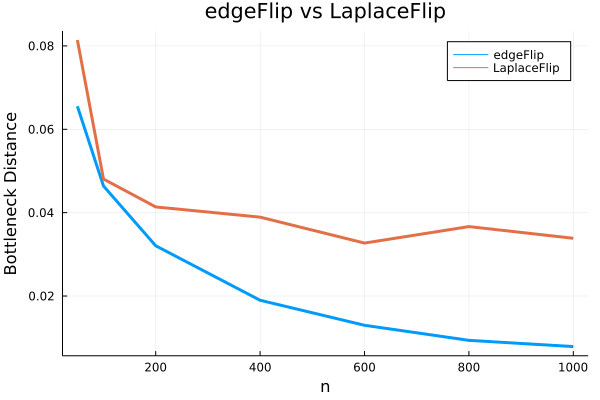

In [25]:
plt = plot(title="edgeFlip vs LaplaceFlip", xlabel="n", ylabel="Bottleneck Distance")
plot!(plt, N,
        mean(results_eflip[1], dims=1)',
        # ribbon=std(results_eflip[1], dims=1),
        ms=:o,
        label = "edgeFlip",
        lw=3, fillapha=0.01,
    )
plot!(plt, N,
    mean(results_lflip[1], dims=1)',
    # ribbon=std(results_eflip[1], dims=1),
    ms=:o,
    label="LaplaceFlip",
    lw=3, fillapha=0.01,
)